# Importing Libraries 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Data importing and Pre-processing 

In [15]:
df=pd.read_csv("/Users/saikarthik/Desktop/Nexus-S1 Deakin /data.csv")

In [16]:
df.head()


,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [17]:
df.tail()

,timestamp,value
22690,2014-02-19 15:05:00,98.185415
22691,2014-02-19 15:10:00,97.804168
22692,2014-02-19 15:15:00,97.135468
22693,2014-02-19 15:20:00,98.056852
22694,2014-02-19 15:25:00,96.903861


In [18]:
df.shape

(22695, 2)

In [19]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [20]:
data_converted = pd.concat([df[['timestamp']], df.drop('timestamp', axis=1).astype('float32')], axis=1)


In [21]:
df=data_converted

In [22]:
df.to_csv("cleaned.csv")

# Exploratory Data Analysis

In [ ]:
mean_value = df['value'].mean()
median_value = df['value'].median()
std_dev_value = df['value'].std()

mean_value, median_value, std_dev_value


In [ ]:
sns.histplot(df["value"])

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='value', data=df)
plt.title('Value over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

# Models 

## PyOD

In [23]:
X = df[['value']].values


In [24]:
n_train = int(len(X) * 0.8)
X_train = X[:n_train]
X_test = X[n_train:]

In [25]:
clf = ABOD(contamination=0.1, method='fast')  
clf.fit(X_train)


ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [26]:
y_test_pred = clf.predict(X_test)  
y_test_scores = clf.decision_function(X_test)  
y_test_proba = clf.predict_proba(X_test) 

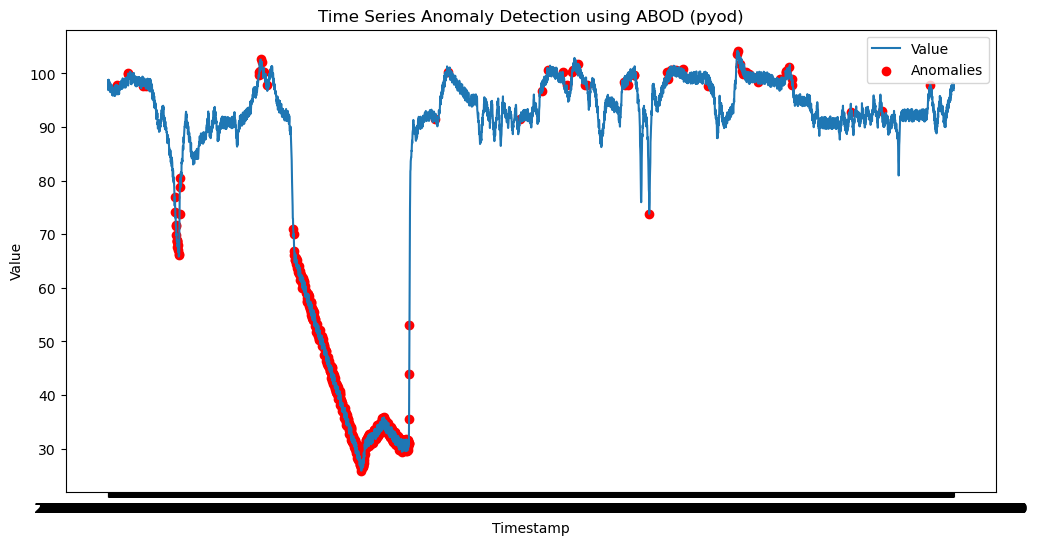

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'][n_train:], X_test, label='Value')
plt.scatter(df['timestamp'][n_train:][y_test_pred == 1], X_test[y_test_pred == 1], color='red', label='Anomalies')
plt.title('Time Series Anomaly Detection using ABOD (pyod)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


## DeepAnt 

In [3]:
data = pd.read_csv('cleaned.csv')
values = data['value'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [4]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [5]:
look_back = 50  # History window size
X, Y = create_dataset(scaled_values, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')


2024-07-12 20:49:20.276403: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-12 20:49:20.276434: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-12 20:49:20.276442: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-12 20:49:20.276488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-12 20:49:20.276505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/50


2024-07-12 20:49:23.199179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-12 20:49:26.242839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


567/567 - 4s - loss: 0.0238 - val_loss: 0.0170 - 4s/epoch - 6ms/step
Epoch 2/50
567/567 - 3s - loss: 0.0141 - val_loss: 0.0154 - 3s/epoch - 5ms/step
Epoch 3/50
567/567 - 3s - loss: 0.0133 - val_loss: 0.0107 - 3s/epoch - 5ms/step
Epoch 4/50
567/567 - 2s - loss: 0.0109 - val_loss: 0.0143 - 2s/epoch - 4ms/step
Epoch 5/50
567/567 - 3s - loss: 0.0122 - val_loss: 0.0085 - 3s/epoch - 4ms/step
Epoch 6/50
567/567 - 3s - loss: 0.0106 - val_loss: 0.0199 - 3s/epoch - 4ms/step
Epoch 7/50
567/567 - 3s - loss: 0.0107 - val_loss: 0.0126 - 3s/epoch - 5ms/step
Epoch 8/50
567/567 - 3s - loss: 0.0096 - val_loss: 0.0106 - 3s/epoch - 5ms/step
Epoch 9/50
567/567 - 3s - loss: 0.0101 - val_loss: 0.0124 - 3s/epoch - 5ms/step
Epoch 10/50
567/567 - 3s - loss: 0.0097 - val_loss: 0.0170 - 3s/epoch - 5ms/step
Epoch 11/50
567/567 - 3s - loss: 0.0100 - val_loss: 0.0126 - 3s/epoch - 5ms/step
Epoch 12/50
567/567 - 3s - loss: 0.0097 - val_loss: 0.0149 - 3s/epoch - 5ms/step
Epoch 13/50
567/567 - 3s - loss: 0.0094 - val_lo

In [8]:
predictions = model.predict(X)
reconstruction_error = np.abs(predictions.flatten() - Y.flatten())


 81/708 [==>...........................] - ETA: 1s

2024-07-12 20:51:51.044042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


708/708 [==============================] - 1s 2ms/step


In [9]:
mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 3 * std_error

In [10]:
anomalies = np.where(reconstruction_error > threshold)[0]


In [11]:
true_labels = np.zeros(len(reconstruction_error))
true_labels[anomalies] = 1

In [12]:
pred_labels = np.zeros(len(reconstruction_error))
pred_labels[reconstruction_error > threshold] = 1

In [13]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')


Precision: 1.00, Recall: 1.00, F1 Score: 1.00


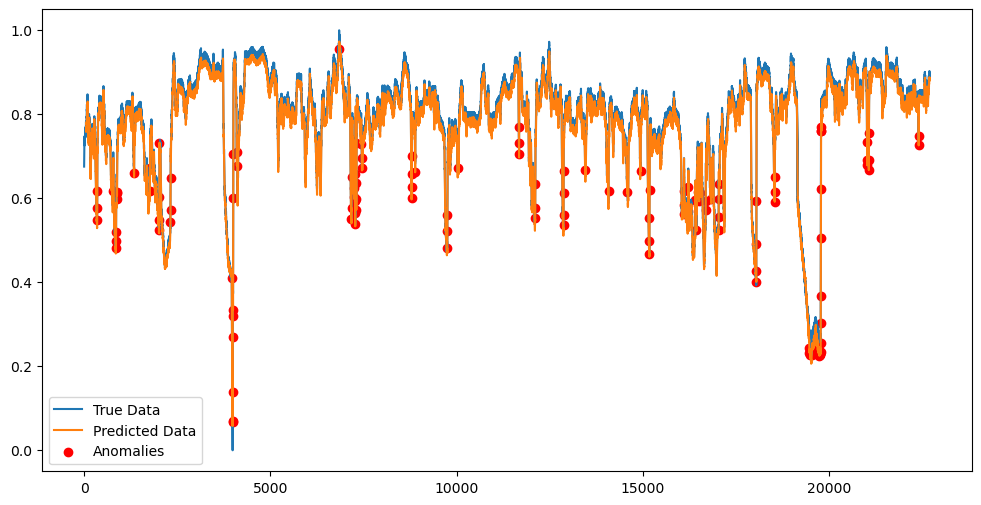

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(scaled_values, label='True Data')
plt.plot(np.arange(look_back, len(predictions) + look_back), predictions, label='Predicted Data')
plt.scatter(anomalies + look_back, predictions[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()
     